# Modified equation to to keep real tax rates 

## Import the model class
This class incorporates most of the methods used to manage a model. 

In [ ]:
# To be usen when notebook is executed in google colab 
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')
  incolab = True  
else:
  incolab = False 

In [14]:
%matplotlib inline

In [15]:
 %load_ext autoreload
 %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from modelclass import model 
model.widescreen()
model.scroll_off()
import modelmf  # Triggers a a dataframe method:  mfcalc 

## Load a pre-existing model, data and descriptions 
The file `pak.pcim` contains a dump of model equations, dataframe, simulation options and variable descriptions. 

In [18]:
### For testing only, not used here
mpak,baseline = model.modelload('../../../../../model_repo/pak_alternative.pcim',run=1,silent=1,keep='No tax change')
mpakdisplay,_ = model.modelload('../../../../../model_repo/pak_alternative.pcim',run=1,silent=1,keep='No tax change')

file read:  C:\modelflow manual\model_repo\pak_alternative.pcim
file read:  C:\modelflow manual\model_repo\pak_alternative.pcim


## Create a experiment  where nominal tax is set to 29

In [20]:
alternative_nominal = baseline.upd(
     '<2023 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 29')
_ = mpak(alternative_nominal,2021,2100,keep=f'Nominal model nominal tax = 29',alfa=0.5)

## Run same expriement but with real price set at 29

First we use update to set the value to 29 in 2024

Then use a new functionality **mfcalc** to do a recusrive calculation taht is not easy to do straight up python. This behavior is 
triggers by the 
>import modelmf

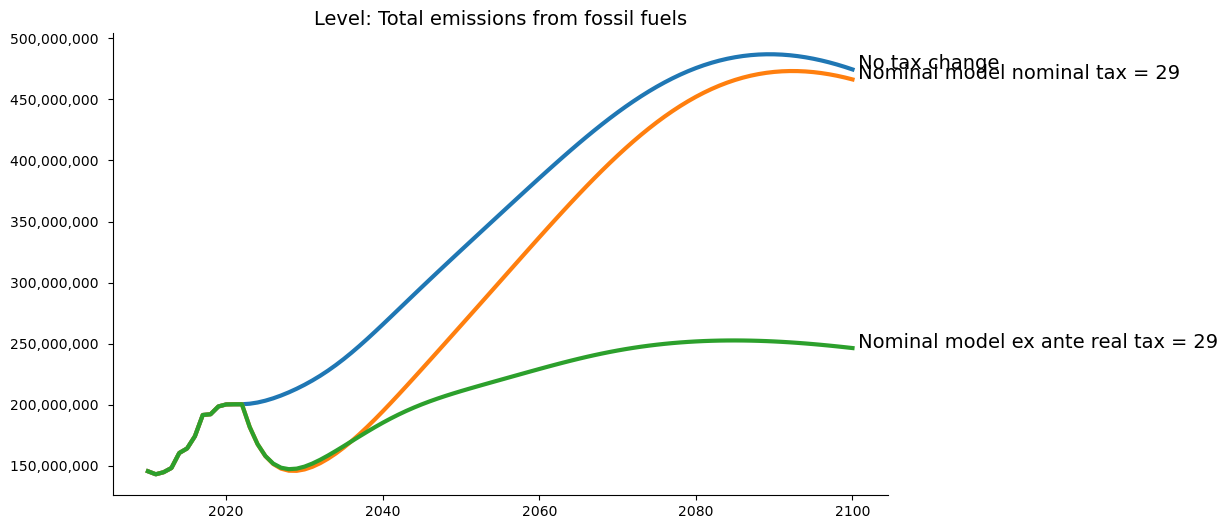

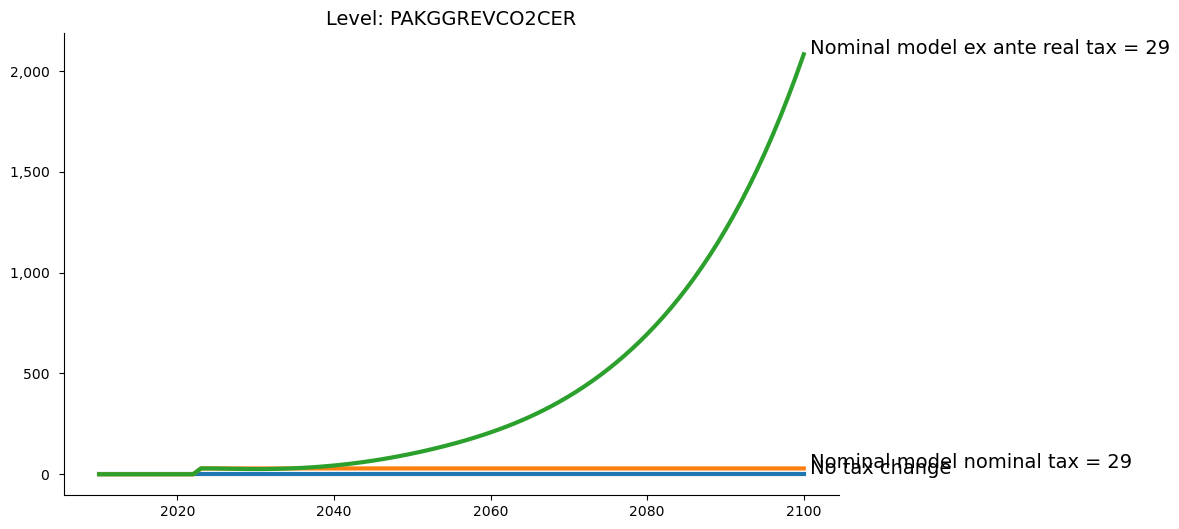

In [21]:
# Set the rate equal to 29 nominal in 2023
alternative_real_exante = baseline.upd(
    '<2023 > PAKGGREVCO2GER PAKGGREVCO2OER PAKGGREVCO2CER = 29')   

alternative_real_exante=alternative_real_exante.mfcalc("""
PAKGGREVCO2GER =PAKGGREVCO2GER(-1)*PAKNECONPRVTXN/PAKNECONPRVTXN(-1)
PAKGGREVCO2OER =PAKGGREVCO2OER(-1)*PAKNECONPRVTXN/PAKNECONPRVTXN(-1)
PAKGGREVCO2CER =PAKGGREVCO2CER(-1)*PAKNECONPRVTXN/PAKNECONPRVTXN(-1)""",2024, 2100) #runs the calculation over the period speciied

_ = mpak(alternative_real_exante,2021,2100,keep=f'Nominal model ex ante real tax = 29',alfa=0.5)

mpak.keep_plot('PAKCCEMISCO2TKN PAKGGREVCO2CER',2010,2100,legend=0);



## Now modify  the mpak model so the carbon tax can be kept constant in real terms

In the mpak model the carbon tax variables ```PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER``` where exogenous variables. Now equations for these variables are introduced to and a **new modified model** is created. 

Each tax variable are now determined by an equation which makes its growth rate follow the growth rate of inflation PAKNECONPRVTXN.

The new equations are made fixable, so the previous behavior can be preserved. The behavior in each year is determined by the **\<name>\_D** variable.
> name = (expression)*(1-\<name>\_D) + \<name>\_X *\<name>\_D 


 |Value of:   \<name>\_D| Value of: name|
 |:--|:--|
 |1|  **\<name>\_X** |
 |0|  **expression**|

In [22]:
mpakreal,_ = mpak.equpdate('''\
<fixable> pct_growth(PAKGGREVCO2CER) = pct_growth(PAKNECONPRVTXN)
<fixable> pct_growth(PAKGGREVCO2OER) = pct_growth(PAKNECONPRVTXN)
<fixable> pct_growth(PAKGGREVCO2GER) = pct_growth(PAKNECONPRVTXN)
''',add_add_factor=False, calc_add=False,newname='Pak model, real adjusted tax')


The model:"Pak model" got new equations, new model name is:"Pak model, real adjusted tax"
New equation for For PAKGGREVCO2CER
Old frml   :new endogeneous variable 
New frml   :FRML <fixable> PAKGGREVCO2CER = ( ((100 * ( (PAKNECONPRVTXN) / (PAKNECONPRVTXN(-1)) -1))) *PAKGGREVCO2CER(-1)/100+PAKGGREVCO2CER(-1)) * (1-PAKGGREVCO2CER_D)+ PAKGGREVCO2CER_X*PAKGGREVCO2CER_D $
Adjust calc:No frml for adjustment calc  

New equation for For PAKGGREVCO2OER
Old frml   :new endogeneous variable 
New frml   :FRML <fixable> PAKGGREVCO2OER = ( ((100 * ( (PAKNECONPRVTXN) / (PAKNECONPRVTXN(-1)) -1))) *PAKGGREVCO2OER(-1)/100+PAKGGREVCO2OER(-1)) * (1-PAKGGREVCO2OER_D)+ PAKGGREVCO2OER_X*PAKGGREVCO2OER_D $
Adjust calc:No frml for adjustment calc  

New equation for For PAKGGREVCO2GER
Old frml   :new endogeneous variable 
New frml   :FRML <fixable> PAKGGREVCO2GER = ( ((100 * ( (PAKNECONPRVTXN) / (PAKNECONPRVTXN(-1)) -1))) *PAKGGREVCO2GER(-1)/100+PAKGGREVCO2GER(-1)) * (1-PAKGGREVCO2GER_D)+ PAKGGREVCO2GER_X*PA

## No tax change in the real model. 


In [23]:

baseline_real = baseline.mfcalc('''
PAKGGREVCO2CER_X = PAKGGREVCO2CER
PAKGGREVCO2GER_X = PAKGGREVCO2GER
PAKGGREVCO2OER_X = PAKGGREVCO2OER
PAKGGREVCO2CER_D = 1
PAKGGREVCO2GER_D = 1
PAKGGREVCO2OER_D = 1
''')

_ = mpakreal(baseline_real,2021,2100,alfa=0.5,keep='Real model no tax change')

## Nominal tax of 29 in the real model. 

In [24]:
alternative_real_model_nominal_tax = baseline_real.upd('''
<2023 2100> PAKGGREVCO2CER_X PAKGGREVCO2GER_X PAKGGREVCO2OER_X = 29
''')
_ = mpakreal(alternative_real_model_nominal_tax,2021,2100,alfa=0.5,keep='Real model nominal tax = 29')

## Real tax in the real model 


In [25]:
alternative_real_model_real_tax = baseline_real.upd('''
<2023 2023> 
PAKGGREVCO2CER_X PAKGGREVCO2GER_X PAKGGREVCO2OER_X = 29
<2024 2100> 
PAKGGREVCO2CER_D PAKGGREVCO2GER_D PAKGGREVCO2OER_D = 0 
''')
res = mpakreal(alternative_real_model_real_tax,2021,2100,alfa=0.5,keep='Real model Real tax = 29',silent=1)

# Now look at the results for nominal and real tax. 

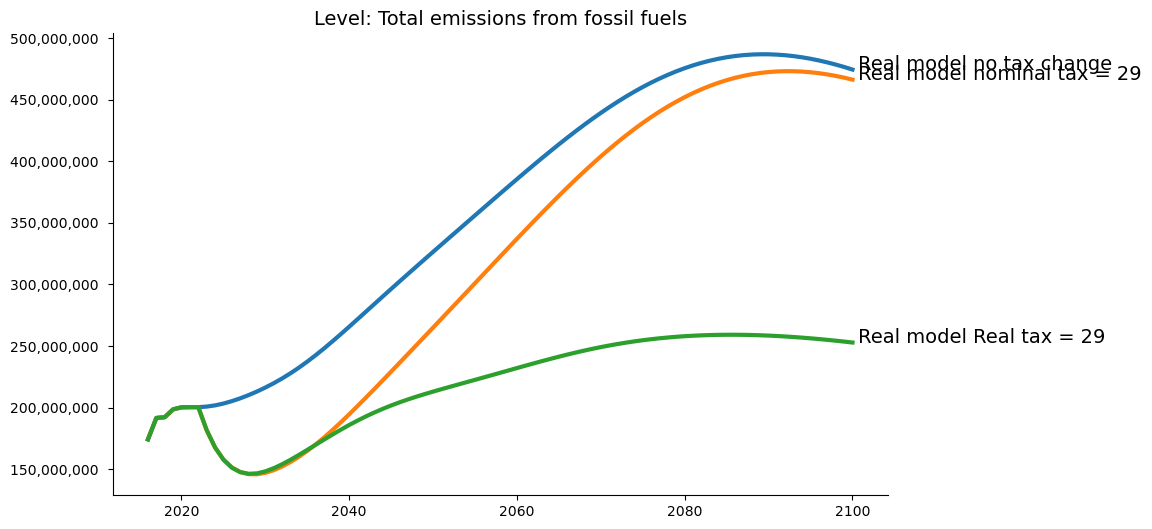

In [26]:
mpakreal.keep_plot('PAKCCEMISCO2TKN',2016,2100,diff=0,legend=0);

In [27]:
mpakdisplay.keep_solutions = {**mpak.keep_solutions,**mpakreal.keep_solutions}

## Check ex ante vs real model

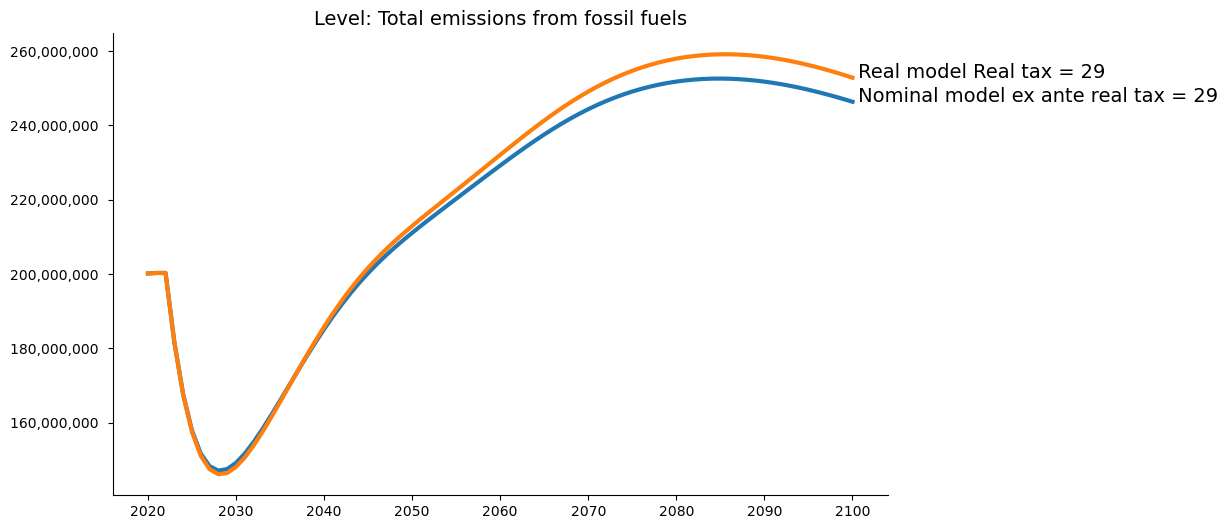

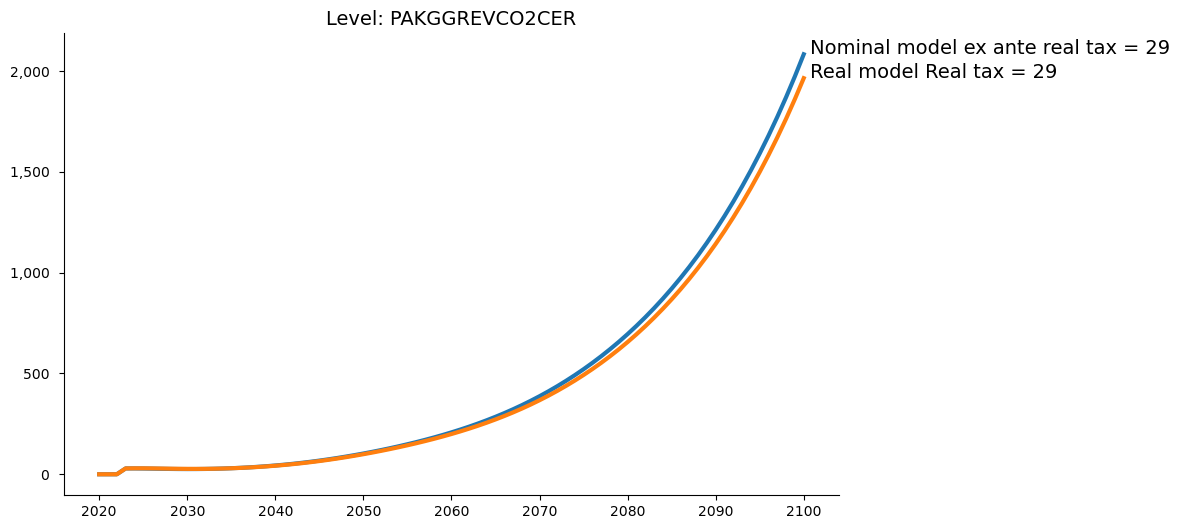

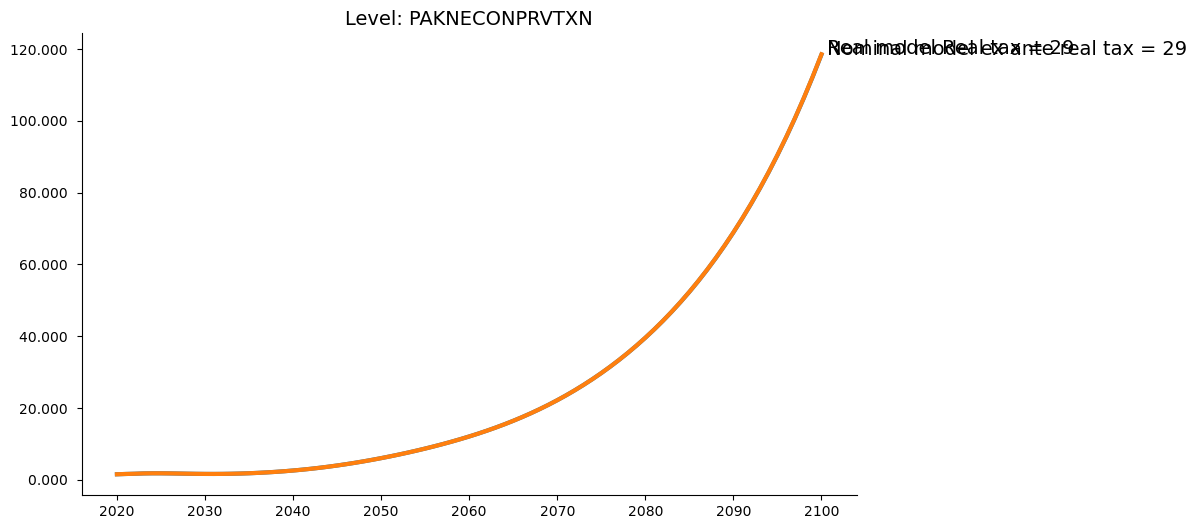

In [28]:
with mpakdisplay.keepswitch(scenarios='Nominal model ex ante real tax = 29|Real model Real tax = 29'):
    mpakdisplay.keep_plot('PAKCCEMISCO2TKN PAKGGREVCO2CER PAKNECONPRVTXN',2020,2100,diff=0);

## Check nominal tax gives the same result in the two models 

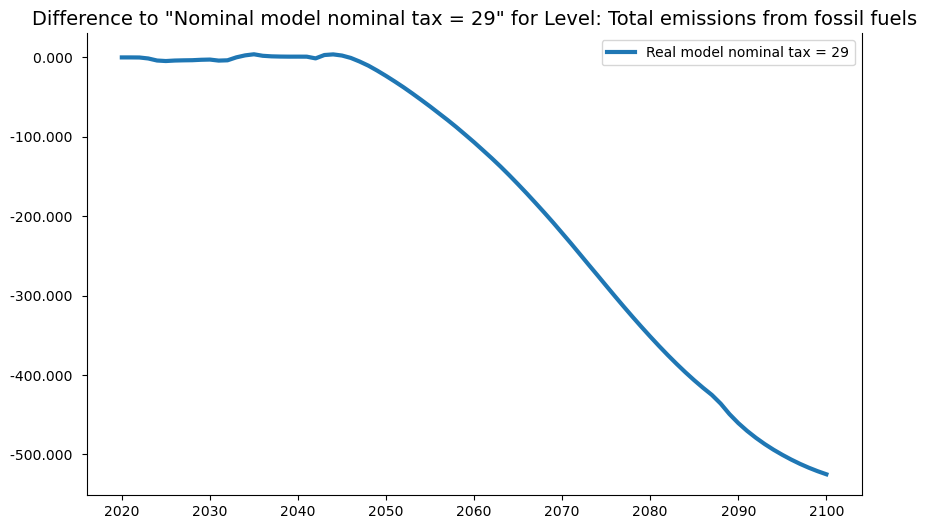

In [29]:
with mpakdisplay.keepswitch(scenarios='Nominal model nominal tax = 29|Real model nominal tax = 29'):
    mpakdisplay.keep_plot('PAKCCEMISCO2TKN',2020,2100,diff=1,legend=1);